In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = '/kaggle/input/smartathon-dataset-zip/dataset'

In [2]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape

(19950, 7)

In [3]:
train_df.head()

class                            image_path           name   xmax   xmin  \
0    3.0  4a48c42c9579ec0399e6c5a3e825e765.jpg        GARBAGE  797.0  701.0   
1    3.0  4a48c42c9579ec0399e6c5a3e825e765.jpg        GARBAGE  932.0  786.0   
2    3.0  4a48c42c9579ec0399e6c5a3e825e765.jpg        GARBAGE  736.0  657.0   
3    7.0  ea906a663da6321bcef78be4b7d1afff.jpg  BAD_BILLBOARD  986.0  786.0   
4    8.0  1c7d48005a12d1b19261b8e71df7cafe.jpg   SAND_ON_ROAD  667.0  549.0   

    ymax   ymin  
0  262.0  211.0  
1  329.0  238.0  
2  275.0  229.0  
3  136.0    0.0  
4  228.0  179.0

In [4]:
train_df[train_df['xmin'] < 0]

class                            image_path               name   xmax  \
16       3.0  b08b7961553eac0b24c7e871836fad9c.jpg            GARBAGE  105.0   
29       4.0  cbc51ac48e7d68a22d17837af794cffa.jpg  CONSTRUCTION_ROAD  537.0   
40       2.0  3fe43374bd1816998ad96704da640c60.jpg           POTHOLES  231.0   
43       4.0  bc2e9e57a48ebccec901fb8a3822a1eb.jpg  CONSTRUCTION_ROAD  143.0   
60       4.0  1b39cbe0913f552cefe1c254991720b1.jpg  CONSTRUCTION_ROAD  625.0   
...      ...                                   ...                ...    ...   
19920    4.0  c3983e130514b206c08f6c3eb2e3bba8.jpg  CONSTRUCTION_ROAD  518.0   
19933    4.0  d0052bbbf2f4c7d306155f563504856e.jpg  CONSTRUCTION_ROAD  256.0   
19936    9.0  70cd44f8028fc3a146fba247ae68f66a.jpg   CLUTTER_SIDEWALK  397.0   
19940    9.0  9d20fda7ea773092aa59494e662b676a.jpg   CLUTTER_SIDEWALK  451.0   
19943    4.0  081e7bb3832ec5bb25276db161a96274.jpg  CONSTRUCTION_ROAD  510.0   

        xmin   ymax   ymin  
16     -21.0  336.0  256.0  
29     -40.0  452.0  162.0  
40     -53.0  575.0  382.0  
43     -40.0  307.0  103.0  
60    -117.0  499.0  150.0  
...      ...    ...    ...  
19920  -75.0  527.0  -21.0  
19933  -25.0  300.0  171.0  
19936  -58.0  312.0  172.0  
19940  -44.0  316.0  210.0  
19943  -92.0  426.0  135.0  

[1999 rows x 7 columns]

In [5]:
train_df.describe()

class          xmax          xmin          ymax          ymin
count  19950.000000  19950.000000  19950.000000  19950.000000  19950.000000
mean       4.055388    572.813634    362.418647    314.202506    201.514937
std        2.502491    264.445257    264.246281    102.133871     85.536614
min        0.000000     30.000000   -397.000000     20.000000   -150.000000
25%        3.000000    357.000000    147.000000    242.000000    149.000000
50%        3.000000    567.000000    350.000000    296.000000    195.000000
75%        4.000000    789.000000    581.000000    372.000000    251.000000
max       10.000000   1384.000000    935.000000    698.000000    500.000000

In [6]:
import matplotlib.pyplot as plt

In [7]:
import random

In [8]:
def plot_images(rows = 10, cols = 3, index = range(100,119)):
    
    fig, axes = plt.subplots(rows,cols,figsize = (25,100))
    
    for i in range(rows):
        for j in range(cols):
            ax = axes[i][j]
            
            ind = random.randint(0,train_df.shape[0])
            img_path = train_df.iloc[ind,:].image_path
            img = cv2.imread(f'{DIR_INPUT}/images/{img_path}', cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            x1 = train_df.iloc[ind,:].xmin*2
            y1 = train_df.iloc[ind,:].ymin*2
            x2 = train_df.iloc[ind,:].xmax*2
            y2 = train_df.iloc[ind,:].ymax*2
            
            img = cv2.rectangle(img, (int(x1),int(y1)) , (int(x2), int(y2)), (255,0,0), 4)
            
            ax.imshow(img)
            ax.set_title(train_df.iloc[ind,:]['name'])

In [9]:
ind = 0
img_path = train_df.iloc[ind,:].image_path
img = cv2.imread(f'{DIR_INPUT}/images/{img_path}', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)

(1080, 1920, 3)


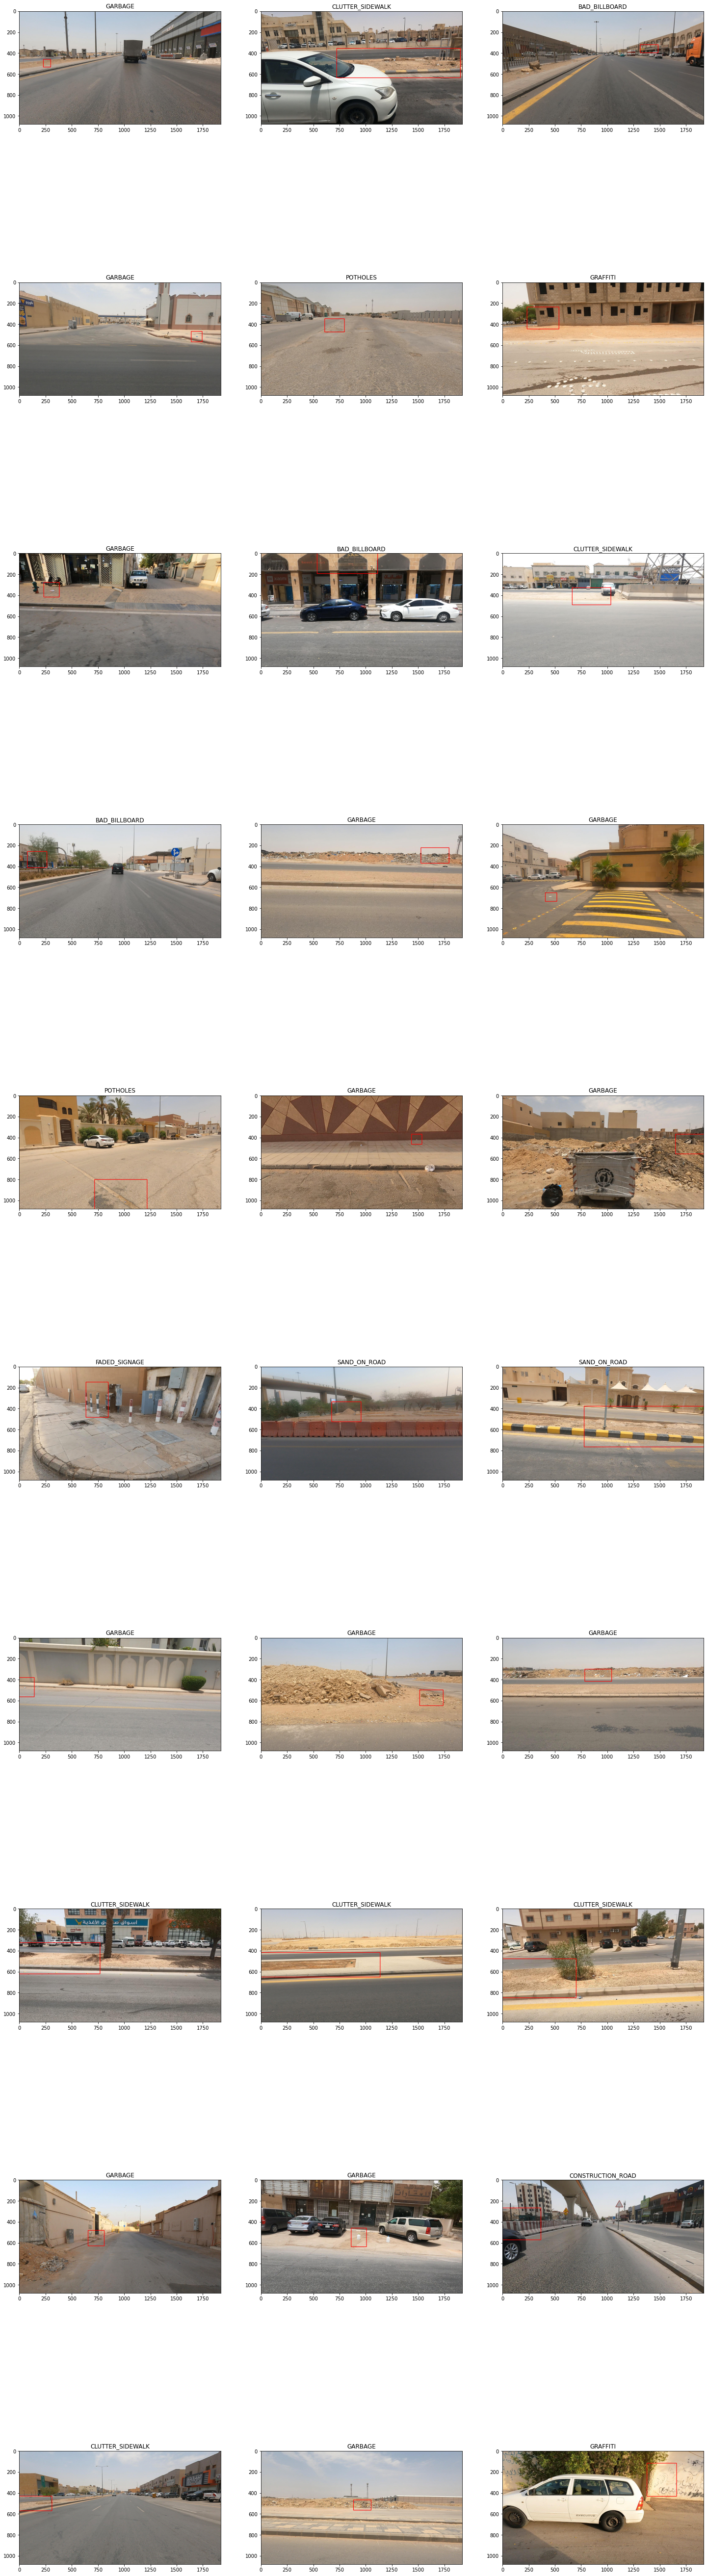

In [10]:
plot_images()

In [11]:
train_df['xmax'] = train_df['xmax'].apply(lambda x : 0 if x < 0 else x*2)
train_df['ymax'] = train_df['ymax'].apply(lambda x : 0 if x < 0 else x*2)
train_df['xmin'] = train_df['xmin'].apply(lambda x : 0 if x < 0 else x*2)
train_df['ymin'] = train_df['ymin'].apply(lambda x : 0 if x < 0 else x*2)

In [12]:
h , w  = 240 , 135

In [13]:
train_df['xmax'] = train_df['xmax'].apply(lambda x : x if x < 1920 else 1920)
train_df['ymax'] = train_df['ymax'].apply(lambda x : x if x < 1080 else 1080)

In [14]:
train_df.describe()

class          xmax          xmin          ymax          ymin
count  19950.000000  19950.000000  19950.000000  19950.000000  19950.000000
mean       4.055388   1137.100551    735.434887    625.931729    403.863559
std        2.502491    514.645132    511.710950    198.039853    168.803524
min        0.000000     60.000000      0.000000     40.000000      0.000000
25%        3.000000    714.000000    294.000000    484.000000    298.000000
50%        3.000000   1134.000000    700.000000    592.000000    390.000000
75%        4.000000   1578.000000   1162.000000    744.000000    502.000000
max       10.000000   1920.000000   1870.000000   1080.000000   1000.000000

In [15]:
train_df['xmax'] = train_df['xmax'].apply(lambda x : x/8)
train_df['ymax'] = train_df['ymax'].apply(lambda x : x/8)
train_df['xmin'] = train_df['xmin'].apply(lambda x : x/8)
train_df['ymin'] = train_df['ymin'].apply(lambda x : x/8)

In [16]:
train_df.describe()

class          xmax          xmin          ymax          ymin
count  19950.000000  19950.000000  19950.000000  19950.000000  19950.000000
mean       4.055388    142.137569     91.929361     78.241466     50.482945
std        2.502491     64.330642     63.963869     24.754982     21.100441
min        0.000000      7.500000      0.000000      5.000000      0.000000
25%        3.000000     89.250000     36.750000     60.500000     37.250000
50%        3.000000    141.750000     87.500000     74.000000     48.750000
75%        4.000000    197.250000    145.250000     93.000000     62.750000
max       10.000000    240.000000    233.750000    135.000000    125.000000

In [17]:
train_df['class'] = train_df['class'].astype(int)

In [18]:
## unique images
image_ids = train_df['image_path'].unique()

In [19]:
len(list(image_ids))

7874

In [20]:
valid_ids = image_ids[-1500:]
train_ids = image_ids[:-1500]

In [21]:
valid_df = train_df[train_df['image_path'].isin(valid_ids)]
train_df = train_df[train_df['image_path'].isin(train_ids)]

In [22]:
valid_df.shape

(3903, 7)

In [23]:
train_df.shape

(16047, 7)

In [24]:
class CreateDataset(Dataset):

    def __init__(self, dataframe, image_dir , transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_path'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_path'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = records['class']
        labels = labels.to_numpy(dtype= np.int64)
        labels = torch.from_numpy(labels)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        
        
        target = {}
        target['boxes'] = torch.from_numpy(boxes)
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [25]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [26]:
CLASSES = train_df['name'].unique()
CLASSES = list(CLASSES)
CLASSES.append('__background__')
CLASSES

['GARBAGE',
 'BAD_BILLBOARD',
 'SAND_ON_ROAD',
 'GRAFFITI',
 'POTHOLES',
 'CLUTTER_SIDEWALK',
 'CONSTRUCTION_ROAD',
 'BROKEN_SIGNAGE',
 'UNKEPT_FACADE',
 'FADED_SIGNAGE',
 '__background__']

In [27]:
num_classes = len(CLASSES)

In [28]:
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [29]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


In [30]:
def collate_fn(batch):
    return tuple(zip(*batch))

DIR_TRAIN = '/kaggle/input/smartathon-dataset-zip/dataset/images'
train_dataset = CreateDataset(train_df, DIR_TRAIN,get_train_transform())
valid_dataset = CreateDataset(valid_df, DIR_TRAIN,get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

NameError: name 'get_train_transform' is not defined

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 5

In [ ]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


In [ ]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   